# Llama2 7b SFT


## Setup Environment

In [1]:
!pip install -q -U transformers datasets accelerate peft trl bitsandbytes wandb huggingface_hub 

DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset

In [3]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

HF_TOKEN = os.getenv("HF_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")

In [4]:
from huggingface_hub import login
login()

Make sure to set Huggingface CLI token

## Download model

In [4]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

## Download a Dataset

In [14]:
# Load the databricks dataset from Hugging Face
from datasets import load_dataset

dataset = load_dataset("yahma/alpaca-cleaned", split="train")

## Explore dataset

In [15]:
print(f'Number of prompts: {len(dataset)}')
print(f'Column names are: {dataset.column_names}')

Number of prompts: 51760
Column names are: ['input', 'instruction', 'output']


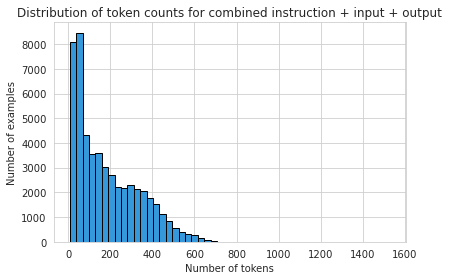

In [17]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
input_token_counts = [len(tokenizer.tokenize(example["input"])) for example in dataset]
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset]
combined_token_counts = [input + instruction + output for input, instruction, output in zip(input_token_counts,instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title)
    plt.xlabel("Number of tokens")
    plt.ylabel("Number of examples")
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
# plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
# plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + input + output")

In [26]:
dataset.to_pandas().sample(n=5)

,input,instruction,output
16477,The rain is coming down hard.,Rewrite the given sentence as an exclamatory s...,"Wow, the rain is coming down so hard!"
33782,,Select all countries that are located in Africa,Here is a list of countries located in Africa:...
49783,The person singing was loudly,Rearrange the following sequence of words so t...,The person was singing loudly.
31203,,How do the jobs of scientists and engineers di...,Scientists and engineers both work in fields r...
39903,"Alarm went off early this morning, I really ne...",Edit the text and restructure the sentences to...,"This morning, my alarm went off early and I kn..."


In [6]:
dataset = dataset.rename_columns({'output': 'response', 'input': 'context', 'instruction': 'instruction'})

## Pre-processing dataset

Instruction fine-tuning is a common technique used to fine-tune a base LLM for a specific downstream use-case.

It will help us to format our prompts as follows:


```
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Sea or Mountain

### Response:
I believe Mountain are more attractive but Ocean has it's own beauty and this tropical weather definitely turn you on! SO 50% 50%

### End
```



In [7]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction', 'context', 'response')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """

    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "Input:"
    RESPONSE_KEY = "### Response:"
    END_KEY = "### End"

    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{sample['instruction']}"
    input_context = f"{INPUT_KEY}\n{sample['context']}" if sample["context"] else None
    response = f"{RESPONSE_KEY}\n{sample['response']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)

    sample["text"] = formatted_prompt

    return sample

In [8]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )


# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int, seed, dataset: str):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)

    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["instruction", "context", "response", "text"],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

## Create a bitsandbytes configuration

In [9]:
def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [10]:
def create_peft_config(modules):
    """
    Create Parameter-Efficient Fine-Tuning config for your model
    :param modules: Names of the modules to apply Lora to
    """
    config = LoraConfig(
        r=16,  # dimension of the updated matrices
        lora_alpha=64,  # parameter for scaling
        target_modules=modules,
        lora_dropout=0.1,  # dropout probability for layers
        bias="none",
        task_type="CAUSAL_LM",
    )

    return config

In [11]:
# SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [12]:
def print_trainable_parameters(model, use_4bit=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    if use_4bit:
        trainable_params /= 2
    print(
        f"all params: {all_param:,d} || trainable params: {trainable_params:,d} || trainable%: {100 * trainable_params / all_param}"
    )

## Train

In [13]:
# Load model from HF with user's token and with bitsandbytes config

model_name = "meta-llama/Llama-2-7b-hf"

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:711: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [14]:
## Preprocess dataset

max_length = get_max_length(model)

dataset = preprocess_dataset(tokenizer, max_length, 56, dataset)

Found max lenth: 4096
Preprocessing dataset...


In [15]:
def train(model, tokenizer, dataset, output_dir):
    # Apply preprocessing to the model to prepare it by
    # 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
    model.gradient_checkpointing_enable()

    # 2 - Using the prepare_model_for_kbit_training method from PEFT
    model = prepare_model_for_kbit_training(model)

    # Get lora module names
    modules = find_all_linear_names(model)

    # Create PEFT config for these modules and wrap the model to PEFT
    peft_config = create_peft_config(modules)
    model = get_peft_model(model, peft_config)

    # Print information about the percentage of trainable parameters
    print_trainable_parameters(model)

    # Training parameters
    trainer = Trainer(
        model=model,
        train_dataset=dataset,
        args=TrainingArguments(
            num_train_epochs=1,
            per_device_train_batch_size=1,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            max_steps=1000,
            learning_rate=2e-4,
            fp16=True,
            logging_steps=50,
            output_dir=output_dir,
            optim="paged_adamw_8bit",
            save_steps=100,
            save_total_limit=3
        ),
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )

    model.config.use_cache = False  # re-enable for inference to speed up predictions for similar inputs

    ### SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
    # Verifying the datatypes before training

    dtypes = {}
    for _, p in model.named_parameters():
        dtype = p.dtype
        if dtype not in dtypes: dtypes[dtype] = 0
        dtypes[dtype] += p.numel()
    total = 0
    for k, v in dtypes.items(): total+= v
    for k, v in dtypes.items():
        print(k, v, v/total)

    do_train = True

    # Launch training
    print("Training...")

    if do_train:
        train_result = trainer.train()
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        print(metrics)

    ###

    # Saving model
    print("Saving last checkpoint of the model...")
    os.makedirs(output_dir, exist_ok=True)
    trainer.model.save_pretrained(output_dir)

    # Free memory for merging weights
    del model
    del trainer
    torch.cuda.empty_cache()


output_dir = "llama2_finetuned"
train(model, tokenizer, dataset, output_dir)

all params: 3,540,389,888 || trainable params: 39,976,960 || trainable%: 1.1291682911958425
torch.float32 302387200 0.08541070604255438
torch.uint8 3238002688 0.9145892939574456
Training...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


Step,Training Loss
50,0.970100
100,0.835000
150,0.859100
200,0.793400
250,0.832800
300,0.831100
350,0.836600
400,0.835000
450,0.819100
500,0.818000


***** train metrics *****
  epoch                    =       0.08
  total_flos               = 33756709GF
  train_loss               =     0.8248
  train_runtime            = 0:58:07.68
  train_samples_per_second =      1.147
  train_steps_per_second   =      0.287
{'train_runtime': 3487.6855, 'train_samples_per_second': 1.147, 'train_steps_per_second': 0.287, 'total_flos': 3.624599114580787e+16, 'train_loss': 0.8247706489562988, 'epoch': 0.08}
Saving last checkpoint of the model...


## Merge weights

In [16]:
model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)
model = model.merge_and_unload()

output_merged_dir = "results/llama2/final_merged_checkpoint"
os.makedirs(output_merged_dir, exist_ok=True)
model.save_pretrained(output_merged_dir, safe_serialization=True)

# save tokenizer for easy inference
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_merged_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('results/llama2/final_merged_checkpoint/tokenizer_config.json',
 'results/llama2/final_merged_checkpoint/special_tokens_map.json',
 'results/llama2/final_merged_checkpoint/tokenizer.json')

## Inference

In [22]:
# Model config use cache enabled for inference
model.config.use_cache = True 

# Specify input
text = "What is Direct Preference Optimization?"

# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Tokenize input text
inputs = tokenizer(text, return_tensors="pt").to(device)

# Get answer
# (Adjust max_new_tokens variable as you wish (maximum number of tokens the model can generate to answer the input))
outputs = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"], max_new_tokens=140, pad_token_id=tokenizer.eos_token_id)

# Decode output & print it
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

What is Direct Preference Optimization?
 Write a description for Direct Preference Optimization.

### Response:
Direct Preference Optimization (DPO) is a machine learning technique that aims to optimize a set of preferences, where each preference is expressed as a vector of weights. The goal is to find the best possible solution that maximizes the total weighted sum of the preferences.

DPO works by iteratively modifying the solution until it reaches a state where no further improvement can be made. In each iteration, the algorithm evaluates the current solution and assigns a score to it based on the preference vectors. The solution with the highest score is then chosen as the best possible solution


## Push model to Hugging Face Hub (Optional)

In [23]:
model.push_to_hub("llama2-fine-tuned-alpaca-1000")

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/akkky02/llama2-fine-tuned-alpaca-1000/commit/0fbbaa34664ff476294755d56b87c47c7a1b8025', commit_message='Upload LlamaForCausalLM', commit_description='', oid='0fbbaa34664ff476294755d56b87c47c7a1b8025', pr_url=None, pr_revision=None, pr_num=None)

In [24]:
tokenizer.push_to_hub("llama2-fine-tuned-alpaca-1000")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/akkky02/llama2-fine-tuned-alpaca-1000/commit/c4f573090efc0bb1fc2f0e21222f63908b981e2e', commit_message='Upload tokenizer', commit_description='', oid='c4f573090efc0bb1fc2f0e21222f63908b981e2e', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("akkky02/llama2-fine-tuned-alpaca-1000")
model = AutoModelForCausalLM.from_pretrained("akkky02/llama2-fine-tuned-alpaca-1000")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Push Repo to Hugging Face Hub (Optional)

In [ ]:
from huggingface_hub import upload_file
up

In [11]:
from huggingface_hub import upload_folder

upload_folder(
    folder_path="../experiments/llama2_7b_base_adapter/",
    repo_id="MAdAiLab/llama2_7b_base_adapter",
    commit_message="Added bnb config for llama2 7b base adapter and other files",
    token=HF_TOKEN
)

adapter_model.safetensors:   0%|          | 0.00/8.40M [00:00<?, ?B/s]


















adapter_model.safetensors:   0%|          | 16.4k/8.40M [00:00<01:07, 125kB/s]



adapter_model.safetensors:   4%|▎         | 295k/8.40M [00:00<00:05, 1.38MB/s]



scheduler.pt: 100%|██████████| 1.06k/1.06k [00:00<00:00, 3.36kB/s]
rng_state.pth: 100%|██████████| 14.2k/14.2k [00:00<00:00, 35.6kB/s]0, 7.56MB/s]




adapter_model.safetensors:  90%|█████████ | 7.59M/8.40M [00:00<00:00, 23.3MB/s]








scheduler.pt: 100%|██████████| 1.06k/1.06k [00:00<00:00, 7.18kB/s]
adapter_model.safetensors: 100%|██████████| 8.40M/8.40M [00:00<00:00, 10.7MB/s]
rng_state.pth: 100%|██████████| 14.2k/14.2k [00:00<00:00, 48.2kB/s]
optimizer.pt:   0%|          | 0.00/16.8M [00:00<?, ?B/s]


optimizer.pt:   2%|▏         | 279k/16.8M [00:00<00:06, 2.72MB/s]


optimizer.pt: 100%|██████████| 16.8M/16.8M [00:01<00:00, 15.2MB/s]
optimizer.pt: 100%|██████████| 16.8M/16.8M [00:01<00:00, 15.3MB/s]
scheduler.pt: 100%|██████████| 

CommitInfo(commit_url='https://huggingface.co/MAdAiLab/llama2_7b_base_adapter/commit/d008086ebe6be8d9f506e5c7798207274088491c', commit_message='Added bnb config for llama2 7b base adapter and other files', commit_description='', oid='d008086ebe6be8d9f506e5c7798207274088491c', pr_url=None, pr_revision=None, pr_num=None)

In [3]:
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import torch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

HF_TOKEN = os.getenv("HF_TOKEN")

def merge_and_push():
    model_name = "meta-llama/Llama-2-7b-hf"
    adapter = "MAdAiLab/llama2_7b_base_adapter"
    compute_dtype = getattr(torch, "float32")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=False,
        bnb_4bit_quant_type="fp4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_name, quantization_config=bnb_config, device_map={"": 0}
    )
    model = PeftModel.from_pretrained(model, adapter)
    # model.save_pretrained("~/final_merged_model/Llama-2-7b-hf-peft")
    # model.tokenizer.save_pretrained("~/final_merged_model/Llama-2-7b-hf-peft")
    model = model.merge_and_unload(progressbar=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    model.push_to_hub('MAdAiLab/llama2_7b_base_merged_model', safe_serialization=True)
    tokenizer.push_to_hub('MAdAiLab/llama2_7b_base_merged_model', safe_serialization=True)   

    return model, tokenizer

model,tokenizer = merge_and_push()


Loading checkpoint shards: 100%|██████████| 2/2 [01:26<00:00, 43.14s/it]


In [30]:
model = model.merge_and_unload(progressbar=True)
model.push_to_hub('MAdAiLab/llama2_7b_base_merged_model', safe_serialization=True)

Unloading and merging model: 100%|██████████| 486/486 [00:00<00:00, 12633.99it/s]
model-00001-of-00006.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]









model-00001-of-00006.safetensors:   0%|          | 360k/4.84G [00:00<22:33, 3.58MB/s]







model-00001-of-00006.safetensors:   0%|          | 8.14M/4.84G [00:00<01:42, 47.1MB/s]




















model-00001-of-00006.safetensors:   0%|          | 16.0M/4.84G [00:00<03:07, 25.7MB/s]


model-00001-of-00006.safetensors:   1%|          | 25.3M/4.84G [00:00<02:01, 39.7MB/s]








model-00001-of-00006.safetensors:   1%|          | 32.0M/4.84G [00:01<02:51, 28.1MB/s]







model-00001-of-00006.safetensors:   1%|          | 48.0M/4.84G [00:01<02:10, 36.7MB/s]




model-00001-of-00006.safetensors:   1%|          | 56.1M/4.84G [00:01<01:50, 43.1MB/s]













model-00001-of-00006.safetensors:   1%|▏         | 64.0M/4.84G [00:01<02:16, 34.9MB/s]








model-00001-of-00006.safetensors:   2%|▏         | 80.0M/4.84G [00:

CommitInfo(commit_url='https://huggingface.co/MAdAiLab/llama2_7b_base_merged_model/commit/43cdaa3a0ad7ebb46ecb1352d08df60721943cec', commit_message='Upload LlamaForCausalLM', commit_description='', oid='43cdaa3a0ad7ebb46ecb1352d08df60721943cec', pr_url=None, pr_revision=None, pr_num=None)

In [23]:

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

# Needed for LLaMA tokenizer
tokenizer.pad_token = tokenizer.eos_token
# Model config use cache enabled for inference
model.config.use_cache = True 

# Specify input
text = "Who was the first president of India?"

# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Tokenize input text
inputs = tokenizer(text, return_tensors="pt").to(device)

# Get answer
# (Adjust max_new_tokens variable as you wish (maximum number of tokens the model can generate to answer the input))
outputs = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"], max_new_tokens=255, pad_token_id=tokenizer.eos_token_id)

# Decode output & print it
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Who was the first president of India?
 Who was the first president of India?
Ans: Dr. Rajendra Prasad was the first president of India.
Who was the first president of India? Who was the first president of India?
Who was the first president of India?
Who was the first president of India? Who was the first president of India?
Who was the first president of India? Who was the first president of India?


In [ ]:
!lm_eval --model hf \
    --model_args pretrained=meta-llama/Llama-2-7b-hf \
    --tasks blimp_causative \
    --device cuda:0 \
    --batch_size auto:4

In [8]:
import lm_eval

# tasks = ['truthfulqa_mc1','truthfulqa_mc2','arithmetic_2ds','arithmetic_4ds','blimp_causative','mmlu_global_facts']

!lm_eval --model hf \
    --model_args pretrained=MAdAiLab/llama2_7b_base_adapter_merged_final \
    --tasks blimp_causative \
    --device cuda:0 \
    --batch_size auto \
    --output_path ./outputs \
    --log_samples


2024-02-16:19:31:24,949 INFO     [__main__.py:200] Verbosity set to INFO
2024-02-16:19:31:24,950 INFO     [__init__.py:358] lm_eval.tasks.initialize_tasks() is deprecated and no longer necessary. It will be removed in v0.4.2 release. TaskManager will instead be used.
2024-02-16:19:31:37,068 INFO     [__main__.py:276] Selected Tasks: ['blimp_causative']
2024-02-16:19:31:37,069 INFO     [__main__.py:277] Loading selected tasks...
2024-02-16:19:31:37,069 INFO     [evaluator.py:95] Setting random seed to 0
2024-02-16:19:31:37,069 INFO     [evaluator.py:99] Setting numpy seed to 1234
2024-02-16:19:31:37,069 INFO     [evaluator.py:103] Setting torch manual seed to 1234
2024-02-16:19:31:38,065 WARNING  [logging.py:61] Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
2024-02-16:19:31:38,065 INFO     [huggingface.py:161] Using device 'cuda:0'
Loading check

In [28]:
!lm_eval --model_args

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-02-16:16:55:11,920 INFO     [utils.py:145] Note: detected 255 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2024-02-16:16:55:11,920 INFO     [utils.py:148] Note: NumExpr detected 255 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-02-16:16:55:11,920 INFO     [utils.py:160] NumExpr defaulting to 8 threads.
2024-02-16:16:55:12,077 INFO     [config.py:58] PyTorch version 2.2.0 available.
usage: lm_eval [-h] [--model MODEL] [--tasks task1,task2]
               [--model_args MODEL_ARGS] [--num_fewshot N]
               [--batch_size auto|auto:N|N] [--max_batch_size N]
               [--device DEVICE] [--output_path DIR|DIR/file.json]
               [--limit N|0<N<1] [--use_cache DIR]
               [--decontamination_ngrams_path DECONTAMINATION_NGRAMS_PATH]
               [--check_integrity] [--write_out] [--log_samples]
               [--show_config] [--include_path DIR] [--gen_kwargs GEN_KWARGS]
         

In [4]:
from huggingface_hub import upload_folder

upload_folder(
    folder_path="../experiments/MAdAiLab/llama2_7b_SGD_Cosine",
    repo_id="MAdAiLab/llama2_7b_SGD_Cosine",
    commit_message="Added bnb config and checkpoints",)

adapter_model.safetensors:   0%|          | 0.00/8.40M [00:00<?, ?B/s]









adapter_model.safetensors:   7%|▋         | 606k/8.40M [00:00<00:01, 5.75MB/s]



scheduler.pt: 100%|██████████| 1.06k/1.06k [00:00<00:00, 5.25kB/s]
rng_state.pth: 100%|██████████| 14.2k/14.2k [00:00<00:00, 63.5kB/s]




adapter_model.safetensors:  36%|███▋      | 3.05M/8.40M [00:00<00:00, 7.91MB/s]






rng_state.pth: 100%|██████████| 14.2k/14.2k [00:00<00:00, 71.3kB/s]




scheduler.pt: 100%|██████████| 1.06k/1.06k [00:00<00:00, 4.61kB/s]








adapter_model.safetensors: 100%|██████████| 8.40M/8.40M [00:01<00:00, 5.15MB/s]
rng_state.pth: 100%|██████████| 14.2k/14.2k [00:00<00:00, 66.0kB/s]



scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]
optimizer.pt: 100%|██████████| 16.8M/16.8M [00:02<00:00, 8.27MB/s]
scheduler.pt: 100%|██████████| 1.06k/1.06k [00:00<00:00, 2.23kB/s]
optimizer.pt: 100%|██████████| 16.8M/16.8M [00:02<00:00, 6.24MB/s]



optimizer.pt: 100%|██████████| 16.8M/16.8M [00:02<00:

CommitInfo(commit_url='https://huggingface.co/MAdAiLab/llama2_7b_SGD_Cosine/commit/d93ffb44495f79c3082b3e0e684f7bc4e4b646ae', commit_message='Added bnb config and checkpoints', commit_description='', oid='d93ffb44495f79c3082b3e0e684f7bc4e4b646ae', pr_url=None, pr_revision=None, pr_num=None)